In [ ]:
from torchvision.datasets.utils import download_url

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz"
download_url(dataset_url, '.')

100%|██████████| 812M/812M [00:20<00:00, 39.0MB/s]


In [ ]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
from torch.utils.data import dataset
import os

Data_dir='./data/oxford-iiit-pet/images'
files=os.listdir(Data_dir)
files[:1]

['keeshond_200.jpg']

In [ ]:
len(files)

7393

In [ ]:
def parse_breed(fname):
  parts=fname.split('_')
  return ' '.join(parts[:-1])


parse_breed(files[1])

'pug'

In [ ]:
from PIL import Image

In [ ]:
def open_image(path):
  with open(path,'rb') as f:
    img=Image.open(f)
    return img.convert('RGB')

In [ ]:
from torch.utils.data import Dataset
import os

class PetsDataset(Dataset):
  def __init__(self,root,transform):
    super().__init__()
    self.root=root
    self.files=[fname for fname in os.listdir(root) if fname.endswith('jpg')]
    self.classes=list(set(parse_breed(fname) for fname in files))
    self.transform=transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self,i):
    fname=self.files[i]
    fpath=os.path.join(self.root,fname)
    img=self.transform(open_image(fpath))
    class_idx=self.classes.index(parse_breed(fname))
    return img,class_idx



In [ ]:
import matplotlib.pyplot as plt



In [ ]:
import torchvision.transforms as T

img_size=224
imagenet_stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset=PetsDataset(Data_dir,T.Compose([T.Resize(img_size),
                                       T.Pad(8,padding_mode='reflect'),
                                        T.RandomCrop(img_size),
                                        T.ToTensor(),
                                        T.Normalize(*imagenet_stats)]))

len(dataset)

7390

In [ ]:
image,label=dataset[0]
print(image.shape)

torch.Size([3, 224, 224])


In [ ]:
from ast import increment_lineno
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(image,means,std):
  if len(image.shape)==3:
    image=image.unsqueeze(0)
  means=torch.tensor(means).reshape(1,3,1,1)
  std=torch.tensor(std).reshape(1,3,1,1)
  return image *std+means

def show_image(img_tensor,label):
  print('label : ',dataset.classes[label],'('+str(label)+')')
  img_tensor=denormalize(img_tensor,*imagenet_stats)[0].permute((1,2,0))
  plt.imshow(img_tensor)

label :  basset hound (26)


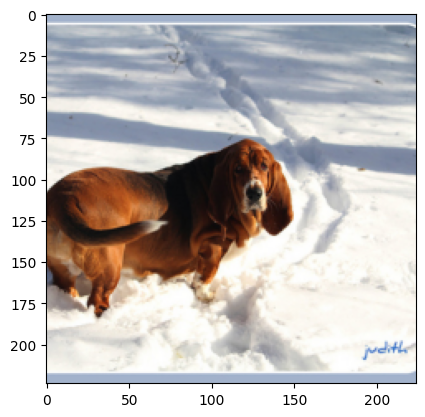

In [ ]:
show_image(*dataset[2])

In [ ]:
from torch.utils.data import DataLoader,random_split

val_pct=0.1
val_size=int(val_pct*len(dataset))

train_ds,val_ds=random_split(dataset,[len(dataset)-val_size,val_size])
len(train_ds),len(val_ds)

(6651, 739)

In [ ]:
bs=256

train_dl=DataLoader(train_ds,batch_size=bs,shuffle=True,num_workers=3,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=bs,num_workers=3,pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
len(train_dl),len(val_dl)

(26, 3)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for image,label in dl:
    fig,ax=plt.subplots(figsize=(16,16))
    ax.set_xticks([]);ax.set_yticks([])
    image=denormalize(image[:64],*imagenet_stats)
    ax.imshow(make_grid(image,nrow=8).permute(1,2,0))
    break

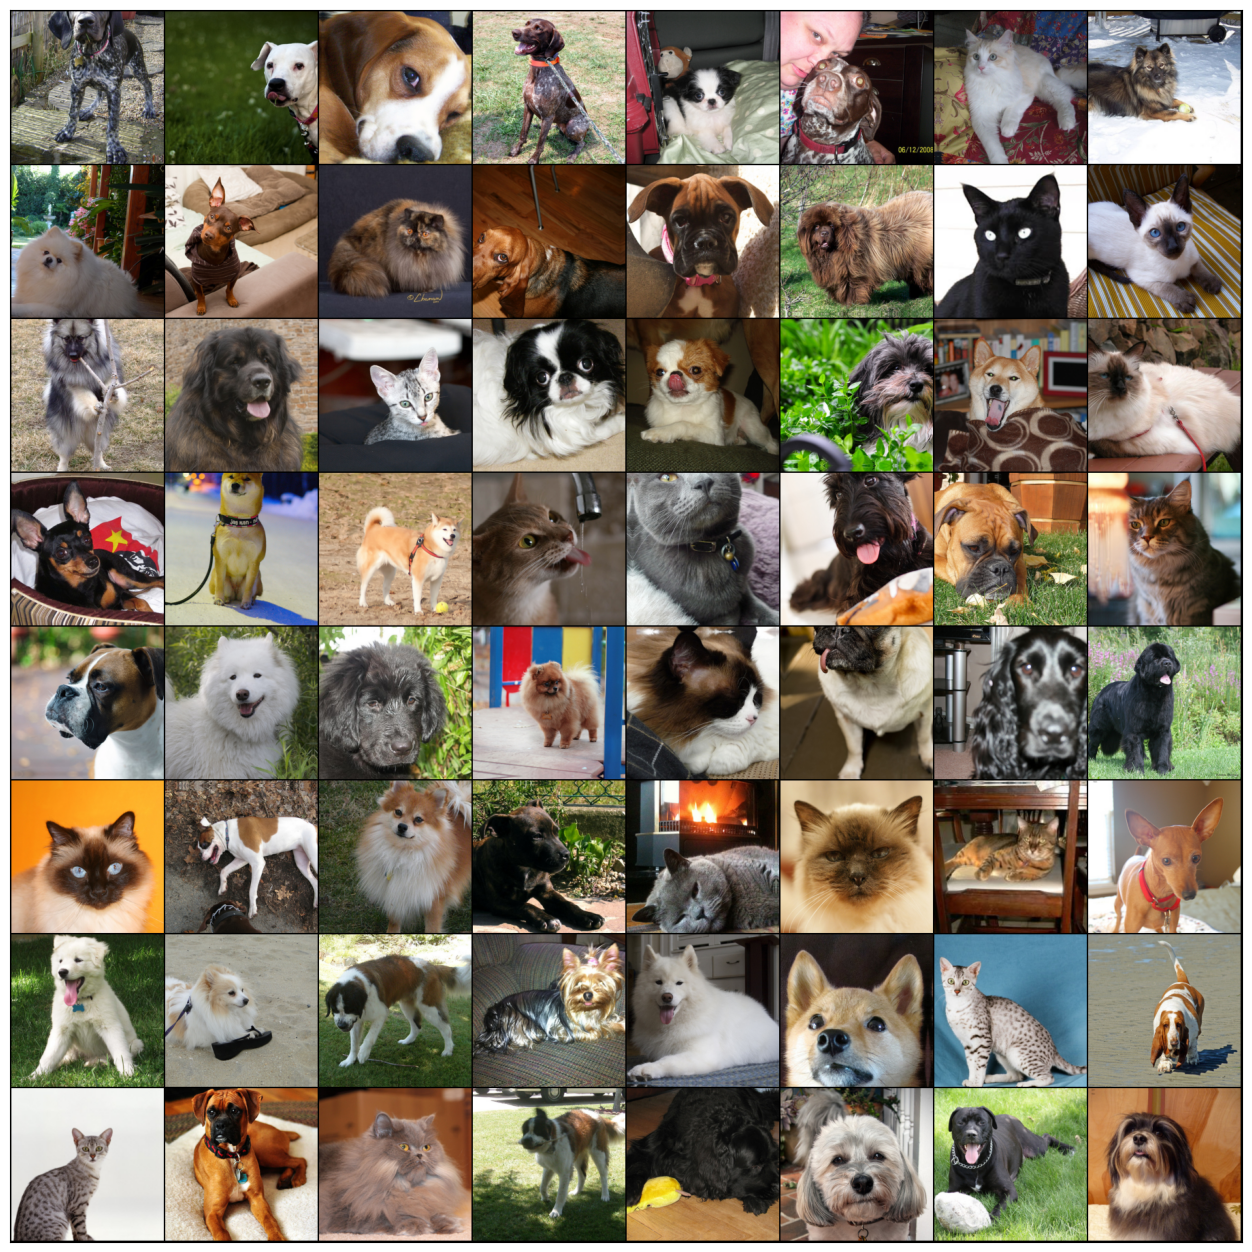

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def accuracy(output,label):
  _,pred=torch.max(output,dim=1)
  return torch.tensor(torch.sum(pred==label).item()/len(pred))


class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    image,label=batch
    pred=self(image)
    loss=F.cross_entropy(pred,label)
    return loss

  def validation_step(self,batch):
    image,label=batch
    pred=self(image)
    val_loss=F.cross_entropy(pred,label)
    val_acc=accuracy(pred,label)
    return {'val_loss':val_loss,'val_acc':val_acc}

  def validation_epoch_end(self,output):
    batch_loss=[x['val_loss'] for x in output]
    epoch_loss=torch.stack(batch_loss).mean()
    batch_acc=[x['val_acc'] for x in output]
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))


  @torch.no_grad()
  def evaluate(self,val_loader):
    self.eval()
    output=[self.validation_step(batch) for batch in val_loader]
    return self.validation_epoch_end(output)




In [ ]:
from torchvision import models

class Petsmodel(ImageClassificationBase):
  def __init__(self,num_classes,pretrained=True):
    super().__init__()
    self.network=models.resnet34(pretrained=pretrained)
    self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)

  def forward(self,xb):
    return self.network(xb)

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return[to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
import torch
from tqdm.notebook import tqdm

def fit(epochs,lr,model,train_dl,val_dl,opt_f=torch.optim.SGD):
  history=[]
  opt=opt_f(model.parameters(),lr)

  for epoch in range(epochs):

    model.train()

    train_losses=[]

    for batch in tqdm(train_dl):
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      opt.step()
      opt.zero_grad()
    result=model.evaluate(val_dl)
    result['train_loss']=torch.stack(train_losses).mean().item()
    model.epoch(epoch,result)
    history.append(result)
  return history


In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,
                  grad_clip=None,opt_func=torch.optim.SGD):

  torch.cuda.empty_cache()
  history=[]

  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)

  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,
                                            steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    model.train()
    train_losses=[]
    lrs=[]
    for batch in tqdm(train_loader):
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      sched.step()

    result=model.evaluate(val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch,result)
    history.append(result)
  return history


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model = Petsmodel(len(dataset.classes))
to_device(model, device);

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


In [ ]:
history = [model.evaluate(val_dl)]
history

[{'val_loss': 3.9021108150482178, 'val_acc': 0.02981025166809559}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00589, train_loss: 1.3651, val_loss: 1808.5957, val_acc: 0.0205


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.9758, val_loss: 3.8950, val_acc: 0.2107


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2642, val_loss: 1.8279, val_acc: 0.4828


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.8511, val_loss: 1.4346, val_acc: 0.5657


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.4987, val_loss: 0.7912, val_acc: 0.7436


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.3082, val_loss: 0.5884, val_acc: 0.8050


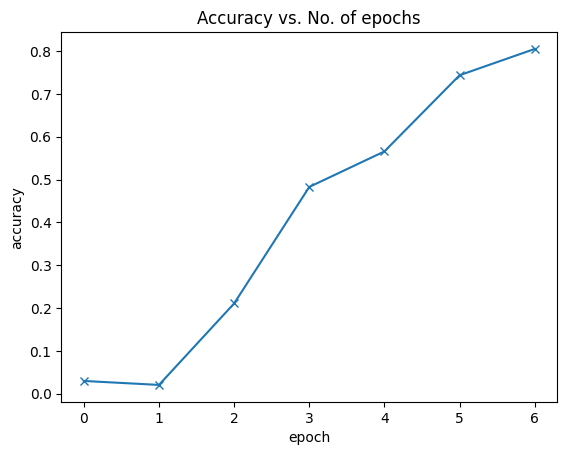

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

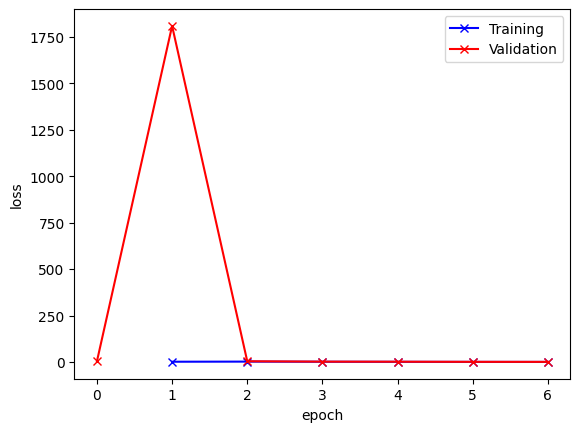

In [ ]:
def plot_losses(history):
  train_losses= [x.get('train_loss') for x in history]
  val_losses=[x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])


plot_losses(history)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]